Title: **Feature Selection – Safety Climate in Indonesia – Likert Scale Data**

# 0. Import Libraries and Packages

In [1]:
#!pip install geneticalgorithm

In [2]:
import pandas as pd                                  # Pandas Dataframe Tools
import numpy as np                                   # Numpy arrays and tools

from numpy.random import randint
from numpy.random import rand

import matplotlib.pyplot as plt                      # for plotting the charts and graphs
%matplotlib inline

from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split # creation of training and testing datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
from sklearn import preprocessing

import time 

from geneticalgorithm import geneticalgorithm as ga


# 1. Loading Dataset and Preliminary pre-processing

In [3]:

# **Importing the Dataset in Pandas Dataframe**
df = pd.read_excel("dataset.xlsx")

# Using the provided dataset in excel, the source of each safety dimension is found
dim1 = [1 ,4 ,6 ,8 ,13,14,15,17]
dim2 = [20,35,38,39,40,45]
dim3 = [56,57,58]
dim4 = [28,31]
dim5 = [18,27,36]
all_dim = [dim1,dim2,dim3,dim4,dim5]
attr_in_dim = {1:'A',2:'B',3:'C',4:'D',5:'E'}
general_info = ['Age', 'Gender', 'Education', 'Position', 'Experience']

# renaming attribute columns to characters with prefixes
counter = 1
for j in all_dim:
    new_names = [(i,attr_in_dim.get(counter)+str(i)) for i in df.loc[:,j].columns.values]
    df.rename(columns = dict(new_names), inplace=True)
    counter+=1

df.rename(columns={'A1': 'A01', 'A4': 'A04','A6':'A06','A8':'A08'}, inplace=True)

#correcting the dim variables
dim1 =['A' + str(x) for x in dim1]
dim2 =['B' + str(x) for x in dim2]
dim3 =['C' + str(x) for x in dim3]
dim4 =['D' + str(x) for x in dim4]
dim5 =['E' + str(x) for x in dim5]

dim1[0]='A01'
dim1[1]='A04'
dim1[2]='A06'
dim1[3]='A08'

all_dim = [dim1,dim2,dim3,dim4,dim5]

# Identify the project type 
df['project'] = 'BLDG'
df.loc[df.head(144).index,'project'] = 'INFRA'

# Clean Likert Scale
for i in all_dim:
    for j in i:
        df[j]=df[j].apply(lambda x: x if (x==int(x)) else None)

# Finding NaN (null) Values
column_names = df.columns
Nan_columns = list()
for col in column_names:
    if (True in np.array(df[col].isnull())):
        Nan_columns.append(col)
Nan_columns

#Replace null values with Mode value of each column
for i in Nan_columns:
    df[i].fillna(df[i].mode()[0],inplace=True)

# Drop manually-labeled columns  -- these columns were manually labeled and was not part of the quesntionnaire responses
df.drop(df.iloc[:,27:40],axis=1,inplace=True)

quantify_likert_scale = {
    1.0:0,
    1.5:0.05,
    2.0:0.10,
    2.5:0.22,
    3.0:0.35,
    3.5:0.50,
    4.0:0.65,
    4.5:0.92,
    5.0:0.90,
    5.5:0.95,
    6.0:1.00
    }

# Create Empty MODEL
global MODEL
MODEL = {} 

# 2. Functions

## 2.1 Assign Age and Experience Categories

In [4]:
def get_age_cat(x):
    if x<20:
        return "17-19"
    elif 20<=x<=29:
        return "20s"
    elif 30<=x<=39:
        return "30s"
    elif 40<=x<=49:
        return "40s"
    elif 50<=x<=59:
        return "50s"
    elif 60<=x:
        return "60s+"
    else:
        return False
    
def get_experience_level(x):
    if x<6:
        return "01 to 05"
    elif 6<=x<=10:
        return "06 to 10"
    elif 11<=x<=15:
        return "11 to 15"
    elif 16<=x<=20:
        return "16 to 20"
    elif 20<x:
        return "20+"
    else:
        return False

In [5]:
#Create "Age Category" and "Experience Level"
df['age_cat'] = df['Age'].apply(get_age_cat)
df['exper_level'] = df['Experience'].apply(get_experience_level)

## 2.2 Assign Safety Classes 

In [6]:
def get_safety_class(given_score):
    high, low = max(quantify_likert_scale.values()), min(quantify_likert_scale.values())
    if given_score < low:
        given_score = low
    elif given_score > high:
        given_score = high
    number_of_classes = 5
    interval = (high-low)/number_of_classes

    for safety_class in range(number_of_classes):
        mid = low+(interval*(safety_class+1))
        if low<=given_score<=mid:
            break

    return safety_class+1

## 2.3 Feature Subset I/O

In [7]:
# STR to subset Converter
def subset2str (subset = []):
    str_subset = ""
    for i in subset:
        str_subset = str_subset + str(i)
    return str_subset

# GENE to STR Convert
def str2subset (str_subset=""):
    subset = []
    for i in str_subset:
        subset.append(int(i))
    return subset

def solution_string(X):
    solution = ""
    counter = 0
    for i in all_dim:
        for j in i:
            solution = solution + str(X[counter])
            counter+=1
        if j not in dim5:solution = solution + '-'
    return solution

In [8]:
def get_attribute_subset(inclusion_matrix=[]):
  temp_list = []
  attribute_subset = list(range(5,27))
  for i in range(len(inclusion_matrix)):
    if inclusion_matrix[i]==1:
      temp_list.append(attribute_subset[i])
  return temp_list


In [9]:
def get_attribute_names_subset(inclusion_matrix=[]):
  temp_list = []
  attribute_subset_names = feature.sort_values()
  for i in range(len(inclusion_matrix)):
    if inclusion_matrix[i]==1:
      temp_list.append(attribute_subset_names[i])
  return temp_list


In [10]:
feature = df.iloc[:,5:27].columns
feature

Index(['A01', 'A04', 'A06', 'A08', 'A13', 'A14', 'A15', 'A17', 'E18', 'B20',
       'E27', 'D28', 'D31', 'B35', 'E36', 'B38', 'B39', 'B40', 'B45', 'C56',
       'C57', 'C58'],
      dtype='object')

## 2.4 Objective (Evaluation Criteria)

In [11]:
def get_classifier(subset):

    xtrain = traindf.iloc[:,get_attribute_subset(subset)]
    xtest = testdf.iloc[:,get_attribute_subset(subset)]
    #global Classifier
    Classifier = 0
    if MODEL['method_name'] == "RF":
        Classifier = RandomForestClassifier(n_estimators=100, criterion = 'gini', random_state=1).fit(xtrain, y_train)
        
    elif MODEL['method_name'] == "SVM":
        Classifier = svm.SVC(kernel='linear').fit(xtrain,y_train)    

    elif MODEL['method_name'] == "KNN":
        Classifier = KNeighborsClassifier(n_neighbors=5).fit(xtrain,y_train)
    
    elif MODEL['method_name'] == "NB":
        Classifier = GaussianNB().fit(xtrain,y_train)
    
    elif MODEL['method_name'] =="Bagging":
        Classifier = BaggingClassifier(KNeighborsClassifier(),random_state=5).fit(xtrain,y_train)
    
    elif MODEL['method_name'] == "AdaBoost":
        Classifier = AdaBoostClassifier(n_estimators=50,random_state=5).fit(xtrain,y_train)
        
    else:
        return False
    
    return Classifier

In [12]:
def get_objective(subset):
    xtest = testdf.iloc[:,get_attribute_subset(subset)]
    return get_classifier(subset).score(xtest,y_true).round(4)

## 2.5 Search Strategies Functions

In [13]:
def BackwardSearch():
    start_time = time.time()
    base = [1 for _ in range(22)]
    for vert in range(len(base)):
        base_accuracy = get_objective(base)
        base_distance = 1
        idx=0
        for horiz in range(len(base)):
            if base[horiz]==0: continue
            if base[horiz]==1: 
                base[horiz]=0 #toggle value
                accuracy = get_objective(base)
                dist = abs(base_accuracy - accuracy)
                if dist <base_distance:
                    base_distance = dist
                    idx=horiz
                base[horiz]=1 # re-toggle value        
        base[idx] = 0 #remove most redundant attribute
        if sum(base)==MODEL['target_num_of_features']:
            MODEL['elapsed_train_time'] = time.time() - start_time
            MODEL['trained'] = True
            MODEL['subset'] = base
            MODEL['accuracy'] = get_objective(base)
            MODEL['cls'] = get_classifier(base)
            return True
    return False    


In [14]:
def ForwardSearch():
    start_time = time.time()
    all_attr = 22
    base = [0 for _ in range(all_attr)]
    for vert in range(all_attr):
        base_acc = 0 
        for horiz in range(all_attr):
            if base[horiz]==0:
                base[horiz]=1 #include attribute
                accuracy = get_objective(base)
                if accuracy>base_acc:
                    base_acc = accuracy
                    idx = horiz
                base[horiz]=0
        
        base[idx] = 1 #add most valuable attribute
        
        if sum(base) == MODEL['target_num_of_features']:
            MODEL['elapsed_train_time'] = time.time() - start_time
            MODEL['trained'] = True
            MODEL['subset'] = base
            MODEL['accuracy'] = get_objective(base)
            MODEL['cls'] = get_classifier(base)

            return True
        
    return False

In [15]:
def GA_Search(X):
    if sum(X) !=MODEL['target_num_of_features']:
        return 10
    return -get_objective(X)

## 2.6 Create Model Function

In [16]:
def Create_MODEL(target_num_of_features:int,search_mode:str,method_name:str,safety_score_mode:str):
    #0. Set Model Parameters
    _MODEL = {
       'target_num_of_features':target_num_of_features,
       'method_name':method_name,
       'search_mode':search_mode,
       'safety_score_mode':safety_score_mode,
       
       # reset results information to None
       'cls':0,
       'subset':[],
       'accuracy':0,
       'elapsed_train_time':0
    }
  
    #1. Quantify Likert Scale and Calcuate Medians for Dimension
    df['D1'] = df[dim1].median(axis=1).map(quantify_likert_scale)
    df['D2'] = df[dim2].median(axis=1).map(quantify_likert_scale)
    df['D3'] = df[dim3].median(axis=1).map(quantify_likert_scale)
    df['D4'] = df[dim4].median(axis=1).map(quantify_likert_scale)
    df['D5'] = df[dim5].median(axis=1).map(quantify_likert_scale)

    #2. Calculate Saefty Score
    if _MODEL['safety_score_mode'] =="SAW":     # Safety_score using SAW Method
        weight = [len(i)/22 for i in all_dim]
        df['safety_score'] = df.loc[:,'D1':'D5'].apply(lambda X: sum([round(x*w,2) for (x,w) in zip (X,weight)]),axis=1)
    elif _MODEL['safety_score_mode'] == "EUC":  #Calculate Safety Score using Euclidean Distance
        euclidean_distance=(df['D1']**2 + df['D2']**2 + df['D3']**2 + df['D4']**2 + df['D5']**2)**0.5   #using Euclidean distance
        # Normalize Safety Score from 0 to 1
        df['safety_score']= preprocessing.normalize([np.array(euclidean_distance)],norm='max').transpose().round(2)
    
    #3. Assign Safety Classes
    df['safety_class'] = df['safety_score'].apply(get_safety_class)

    # for binary class assignment
    df['binary_class'] = df['safety_score'].apply (lambda x: 1 if x>=df.safety_score.mean() else 0) 

    #4. Train-Test Data Split
    global traindf, testdf, y_train, y_true
    traindf, testdf = train_test_split(df,train_size=0.70,random_state=10)
    y_train = traindf['safety_class']
    y_true = testdf['safety_class']
 
    return _MODEL

## 2.7 Train Model Function

In [17]:
def train_model():
    if MODEL['search_mode']=="BSS":
        BackwardSearch()
    elif MODEL['search_mode']=="FSS":
        ForwardSearch()
    elif MODEL['search_mode']=="GA_Search":
        ga_algo_params = {'max_num_iteration': 50,\
                   'population_size':32,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':20}
        ga_model = ga(function=GA_Search,dimension=22,
                    variable_type='bool',
                    algorithm_parameters=ga_algo_params,
                    progress_bar=False)
        start_time = time.time()
        ga_model.run()
        MODEL['elapsed_train_time'] = time.time()-start_time
        MODEL['trained'] = True
        MODEL['subset'] = ga_model.best_variable.astype(int)
        MODEL['accuracy'] = -ga_model.best_function
        MODEL['cls'] = get_classifier(ga_model.best_variable.astype(int))
    
    #Make Prediction
    xtest = testdf.iloc[:,get_attribute_subset(MODEL['subset'])]
    start_time = time.time()
    MODEL['y_predict'] = MODEL['cls'].predict(xtest)
    MODEL['elapsed_predict_time'] = time.time()-start_time
    

## 2.8 Run Model Function

In [18]:
def RUN_MODEL(target:int, search_param:str,method_name:str,safety_score_mode):
    global MODEL
    MODEL = Create_MODEL(target,search_param,method_name,safety_score_mode)
    train_model()
    return MODEL


In [19]:
def MODEL_Results():
    if MODEL['trained']:
        cm=confusion_matrix(y_true,MODEL['y_predict'])
        labels = df.safety_class.sort_values().unique()
        cm_display = ConfusionMatrixDisplay(cm,display_labels=labels).plot()
        print(classification_report(y_true,MODEL['y_predict'],zero_division = 0))
    else:
        print("Model not trained!")
        return False


## 2.9 Export all results to Excel

In [20]:
def results_to_excel():
    applied_methods = ['RF','Bagging','AdaBoost','SVM','NB','KNN']
    SearchStrategies = ['BSS','FSS','GA_Search']
    Target_features = [14,11,6]
    all_results = []

    for method in applied_methods:
        for SearchStrategy in SearchStrategies:
            for target in Target_features:
                ans = RUN_MODEL(target,SearchStrategy,method,"SAW")
                all_results.append((SearchStrategy,method,target,subset2str(ans['subset']),solution_string(ans['subset']),
                                    ans['accuracy'], ans['elapsed_train_time'],ans['elapsed_predict_time'],ans['y_predict']))

    global resultsDF
    resultsDF = pd.DataFrame(all_results,columns=['search','method','target','subset_array','subset','accuracy','Train_Time','Predict_time','y_predict'])

    resultsDF.to_excel("model_results.xlsx")
    


# 3. **RUN** MODEL

In [21]:
RUN_MODEL(14,"BSS","KNN","SAW")

{'target_num_of_features': 14,
 'method_name': 'KNN',
 'search_mode': 'BSS',
 'safety_score_mode': 'SAW',
 'cls': KNeighborsClassifier(),
 'subset': [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 'accuracy': 0.9043,
 'elapsed_train_time': 1.1027019023895264,
 'trained': True,
 'y_predict': array([5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5,
        5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 4, 5, 5, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5,
        5, 5, 4, 5, 5, 5]),
 'elapsed_predict_time': 0.004102945327758789}

 The best solution found:
 [1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.]

 Objective function:
 -0.9255


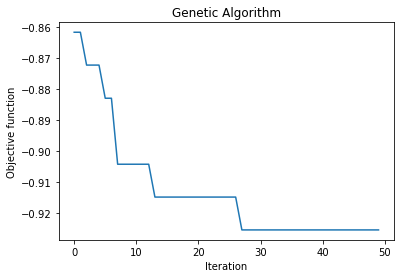

{'target_num_of_features': 14,
 'method_name': 'RF',
 'search_mode': 'GA_Search',
 'safety_score_mode': 'SAW',
 'cls': RandomForestClassifier(random_state=1),
 'subset': array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]),
 'accuracy': 0.9255,
 'elapsed_train_time': 54.18129825592041,
 'trained': True,
 'y_predict': array([5, 5, 4, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5,
        5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 4, 5, 5, 5]),
 'elapsed_predict_time': 0.012714862823486328}

In [23]:
RUN_MODEL(14,"GA_Search","RF","SAW")

 The best solution found:
 [1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0.]

 Objective function:
 -0.9255


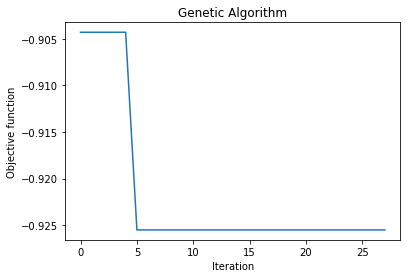


 The best solution found: due to the maximum number of iterations without improvement was met!
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1.]

 Objective function:
 -0.8936


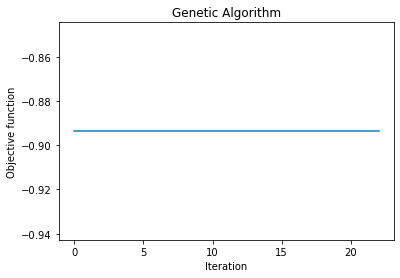


 The best solution found: due to the maximum number of iterations without improvement was met!
 [0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

 Objective function:
 -0.883


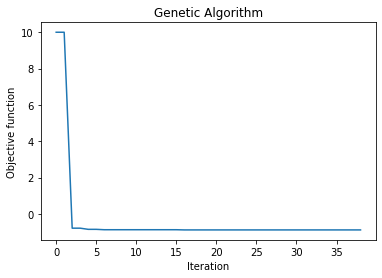


 The best solution found: due to the maximum number of iterations without improvement was met!
 [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.]

 Objective function:
 -0.9149


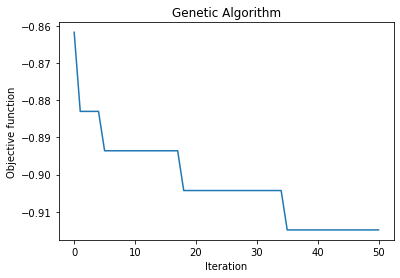

 The best solution found:
 [0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]

 Objective function:
 -0.9043


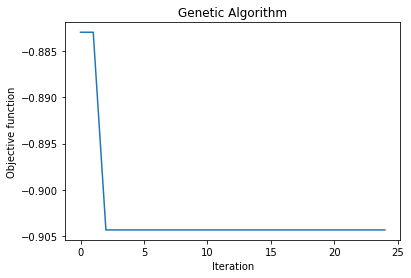


 The best solution found: due to the maximum number of iterations without improvement was met!
 [0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]

 Objective function:
 -0.9149


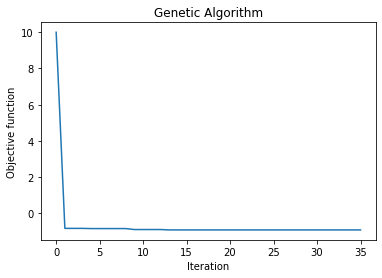


 The best solution found: due to the maximum number of iterations without improvement was met!
 [0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]

 Objective function:
 -0.8404


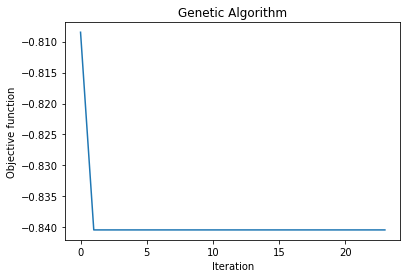


 The best solution found: due to the maximum number of iterations without improvement was met!
 [0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]

 Objective function:
 -0.8404


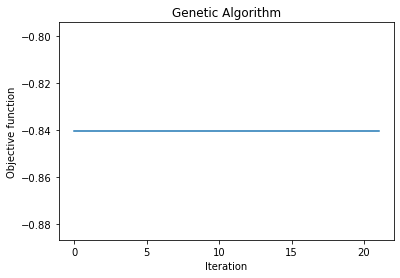


 The best solution found: due to the maximum number of iterations without improvement was met!
 [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

 Objective function:
 -0.8511


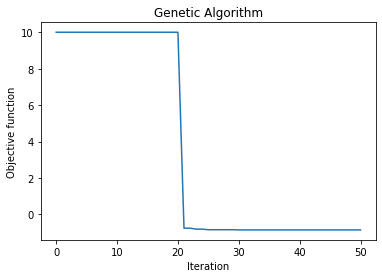

 The best solution found:
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.]

 Objective function:
 -0.9149


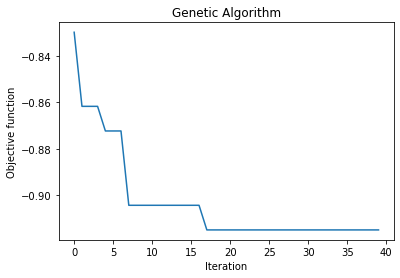


 The best solution found: due to the maximum number of iterations without improvement was met!
 [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.]

 Objective function:
 -0.8936


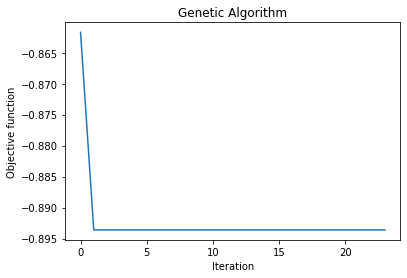


 The best solution found: due to the maximum number of iterations without improvement was met!
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]

 Objective function:
 -0.883


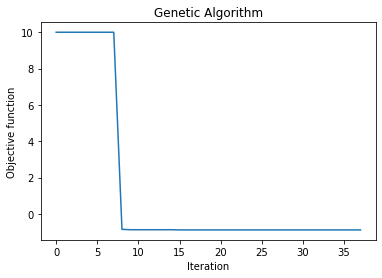


 The best solution found: due to the maximum number of iterations without improvement was met!
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]

 Objective function:
 -0.9043


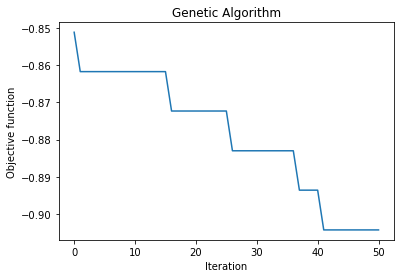

 The best solution found:
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0.]

 Objective function:
 -0.9255


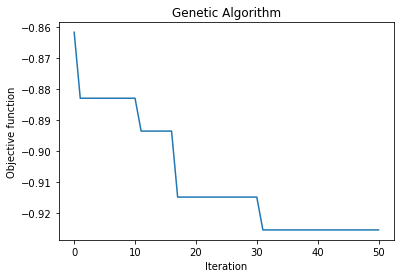

 The best solution found:
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]

 Objective function:
 -0.883


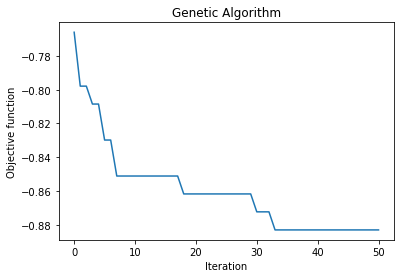

 The best solution found:
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0.]

 Objective function:
 -0.9362


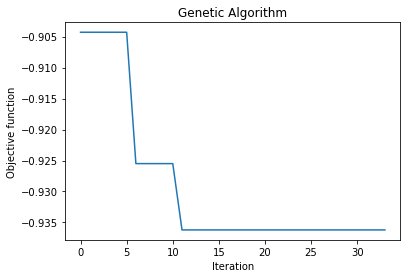


 The best solution found: due to the maximum number of iterations without improvement was met!
 [1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]

 Objective function:
 -0.9043


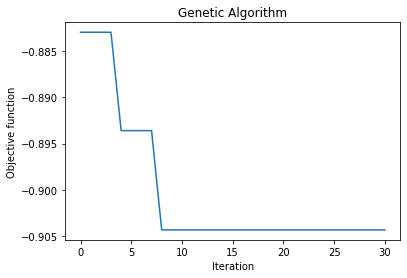


 The best solution found: due to the maximum number of iterations without improvement was met!
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]

 Objective function:
 -0.9043


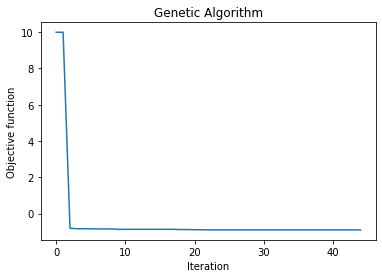

In [22]:
results_to_excel()

# 4. Validate Results

In [74]:
safety_class_labels = [1,2,3,4,5]

## 4.1 for selected 14 Features

Evaluating Results - 14 selected features
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.90      0.64      0.75        14
           5       0.94      1.00      0.97        77

    accuracy                           0.94        94
   macro avg       0.77      0.73      0.74        94
weighted avg       0.92      0.94      0.93        94



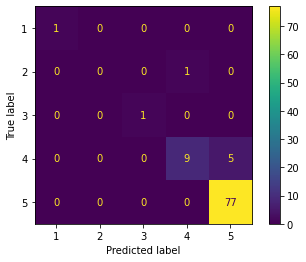

In [77]:
FSS_KNN_14_predicted_class =    [5,5,4,5,5,5,5,5,5,3,5,5,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5,5,4,5,5,5,
                                5,5,5,5,5,5,5,5,5,4,4,5,5,4,5,5,4,5,5,5,5,5,5,5,5,1,5,5,4,5,5,4,5,
                                5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5]
print("Evaluating Results - 14 selected features")
CM14 = confusion_matrix(y_true,FSS_KNN_14_predicted_class,labels=safety_class_labels)
print(classification_report(y_true,FSS_KNN_14_predicted_class,zero_division=0))
ConfusionMatrixDisplay(CM14,display_labels=safety_class_labels).plot()


## 4.2 for selected 11 Features

Evaluating Results - 11 selected features
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.77      0.71      0.74        14
           5       0.95      0.97      0.96        77

    accuracy                           0.93        94
   macro avg       0.74      0.74      0.74        94
weighted avg       0.91      0.93      0.92        94



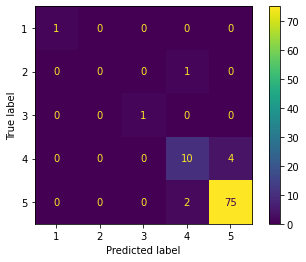

In [78]:
FSS_GNB_11_predicted_class =    [5,5,4,5,5,5,5,5,5,3,5,5,5,5,5,5,5,5,5,4,4,5,5,5,5,5,5,5,4,5,5,5,5,5,5,
                                5,5,5,5,5,5,4,4,5,5,4,5,5,4,4,5,5,5,5,5,5,5,1,5,5,4,5,5,4,5,5,5,5,5,5,5,
                                5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,4,5,5,5]
print("Evaluating Results - 11 selected features")
CM11 = confusion_matrix(y_true,FSS_GNB_11_predicted_class)
print(classification_report(y_true,FSS_GNB_11_predicted_class,zero_division=0))
ConfusionMatrixDisplay(CM11,display_labels=safety_class_labels).plot()


## 4.3 for selected 6 Features

Evaluating Results - 6 selected features
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.75      0.64      0.69        14
           5       0.95      0.97      0.96        77

    accuracy                           0.91        94
   macro avg       0.74      0.72      0.73        94
weighted avg       0.91      0.91      0.91        94



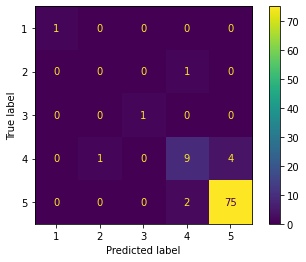

In [79]:
FSS_GNB_06_predicted_class =    [5,5,4,5,5,5,5,5,5,3,5,5,5,5,5,5,5,4,5,4,4,5,5,5,5,5,5,5,4,5,5,5,5,5,5,
                                5,4,5,5,5,5,4,5,5,5,4,5,5,4,5,5,5,5,5,5,5,5,1,5,5,2,5,5,4,5,5,5,5,5,5,
                                5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,4,5,5,5]
print("Evaluating Results - 6 selected features")
CM06 = confusion_matrix(y_true,FSS_GNB_06_predicted_class)
print(classification_report(y_true,FSS_GNB_06_predicted_class,zero_division=0))
ConfusionMatrixDisplay(CM06,display_labels=safety_class_labels).plot()


# Correlation Analysis

In [ ]:
#Correlation of each feature and Safety Score

features = df.iloc[:,5:27].columns

for f in features:
    correl,pval = spearmanr(df[f],df.safety_score)
    print ("Correlation of ",f,"& Safety score",correl.round(4)," pvalue=",pval)

In [ ]:
for d in All_Dimensions:
    print ("Correlation of ",d,"and Normalized Safety score",spearmanr(df[d],df.safety_score))